<a href="https://colab.research.google.com/github/nbisso/TP2-Orga-7506/blob/main/ensable_con_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [322]:
import sys

In [323]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Levanto la data de los DFS

In [324]:
train_labels = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_labels.csv')
train_values = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_values.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datasets_tp2/test_values.csv')



In [325]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [326]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [327]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0


In [328]:
building_id = df_test['building_id']

Feature Engineering

Generamos el Target encode para P(damagegrade | glvlid)

In [329]:
df_values_with_damage = pd.merge(train_values, train_labels, on='building_id')
df_values_with_damage_encoded = pd.get_dummies(df_values_with_damage, columns =["damage_grade"])
#genero la prob de cada geo id por cada damage grade

for i in range(1, 4):
  encoder = ce.TargetEncoder(cols="geo_level_" +  str(i) +"_id")
  df_values_with_damage_encoded["prob1_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_1"])
  df_values_with_damage_encoded["prob2_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_2"])
  df_values_with_damage_encoded["prob3_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_3"])

df_values_with_damage_encoded = df_values_with_damage_encoded.drop(columns=["damage_grade_1","damage_grade_2","damage_grade_3"])

train_values = df_values_with_damage_encoded

for k in range(1, 4):
  df_train_without_dp = train_values[["prob1_geo" + str(k),"prob2_geo"+ str(k),"prob3_geo"+ str(k),"geo_level_" + str(k) + "_id"]].drop_duplicates()
  df_test = df_test.merge(df_train_without_dp,on="geo_level_" + str(k) + "_id",how="left")
  df_test["prob1_geo" + str(k)] = df_test["prob1_geo" + str(k)].fillna(df_test["prob1_geo" + str(k)].mean())  
  df_test["prob2_geo" + str(k)] = df_test["prob2_geo" + str(k)].fillna(df_test["prob2_geo" + str(k)].mean()) 
  df_test["prob3_geo" + str(k)] = df_test["prob3_geo" + str(k)].fillna(df_test["prob3_geo" + str(k)].mean()) 

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

Usamos BinaryEncoder de los categoricos

In [330]:
df_train_encoding = pd.get_dummies(train_values, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])
df_test_encoding = pd.get_dummies(df_test, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])

Dropeamos las columnas que no suman importancia al resultado

In [331]:
 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_use_police"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_use_police"])

 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_health_post"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_health_post"])

 df_train_encoding=df_train_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])
 df_test_encoding=df_test_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])

In [332]:
df_train_encoding

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,2.140686e-17,0.162162,0.837838,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,28830,8,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,6.250001e-02,0.812500,0.125000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,94947,21,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,2.941176e-02,0.360294,0.610294,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,590882,22,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,3.225806e-02,0.838710,0.129032,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,201944,11,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,8.196721e-03,0.614754,0.377049,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1,55,6,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,2.179132e-07,0.928571,0.071429,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
260597,669485,17,2,0,6,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000e+00,0.020408,0.979592,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
260598,602512,17,3,55,6,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,4.545455e-02,0.090909,0.863636,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
260599,151409,26,2,10,14,6,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,2.203390e-01,0.766949,0.012712,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [333]:
df_train_encoding['avg_floors_per_year'] = df_train_encoding[['age', 'count_floors_pre_eq']].groupby('age').transform('mean')

In [334]:
df_test_encoding['avg_floors_per_year'] = df_test_encoding[['age', 'count_floors_pre_eq']].groupby('age').transform('mean')

In [335]:
df_test_encoding.head(2)

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,avg_floors_per_year
0,300051,17,3,20,7,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.142413
1,99355,6,2,25,13,5,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000032,0.999855,0.000112,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.181873


In [336]:
df_train_encoding.head(2)

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,avg_floors_per_year
0,802906,6,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,2.140686e-17,0.162162,0.837838,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.253883
1,28830,8,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,6.250001e-02,0.812500,0.125000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.020671


Armamos y entrenamos el modelo XGBOOST y LGB

In [337]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [339]:
params_lgb = {
        "objective" : "multiclass",
        "num_class":3,
        "metric" : "multi_logloss",
        "boosting": 'gbdt',
        "max_depth" :9,
        "num_leaves" : 40,
        "learning_rate" : 0.05,
        "feature_fraction" : 0.5,
        "min_sum_hessian_in_leaf" : 0.1,
        "max_bin":8200,
        "verbosity" : 1,
        "num_threads":6,
        "seed": 1800
    }

In [340]:
#rf = RandomForestClassifier(n_estimators= 300, criterion= 'gini', max_depth= 25, verbose= 1, min_samples_leaf= 70)
rf = RandomForestClassifier(n_estimators= 200, criterion= 'gini', max_depth= 35, verbose= 1, min_samples_leaf = 70)

In [341]:
# rf.fit(X_train, y_train.values.ravel())

In [342]:
# predicc = rf.predict(X_test)

In [343]:
# f1_score(y_test, predicc, average='micro')

In [344]:
lgb_cl = lgb.LGBMClassifier(**params_lgb,num_boost_round=1000)

In [345]:
xgb_cl = xgb.XGBClassifier(min_child_weight= 5, 
                           learning_rate= 0.1, 
                           gamma= 0.05, 
                           subsample= 0.8,
                           colsample_bytree= 0.3, 
                           colsample_bynode= 0.8,
                           colsample_bylevel= 0.8, 
                           max_depth = 20, 
                           n_estimators = 150)

Entrenamos el modelo ensamblado

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


vcl = VotingClassifier(
     estimators=[('xgb', xgb_cl), ('lgb', lgb_cl), ('rf', rf)],
     voting='hard')


vcl.fit(X_train, y_train)

Muestro la importancia de las features

<BarContainer object of 74 artists>

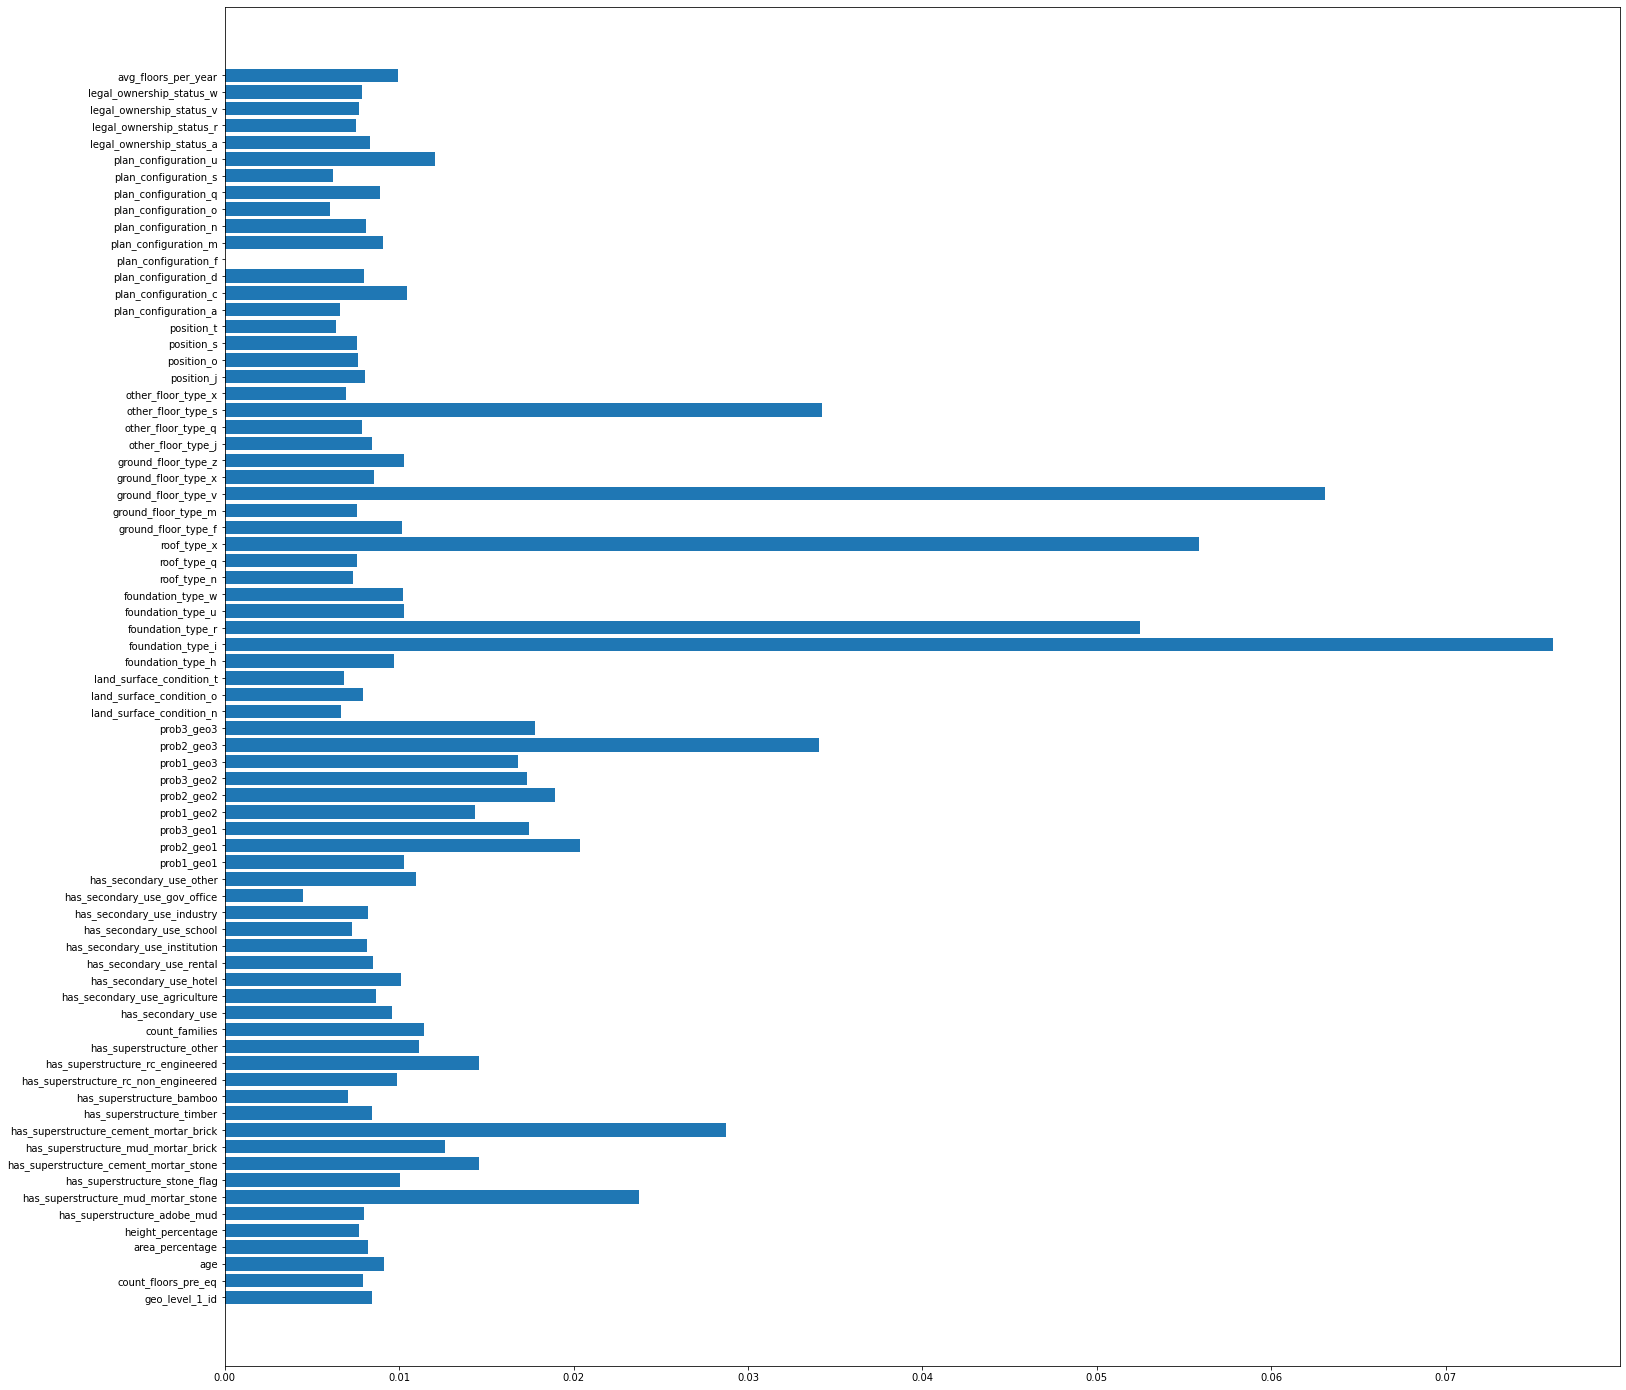

In [363]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, vcl.estimators_[0].feature_importances_)

<BarContainer object of 74 artists>

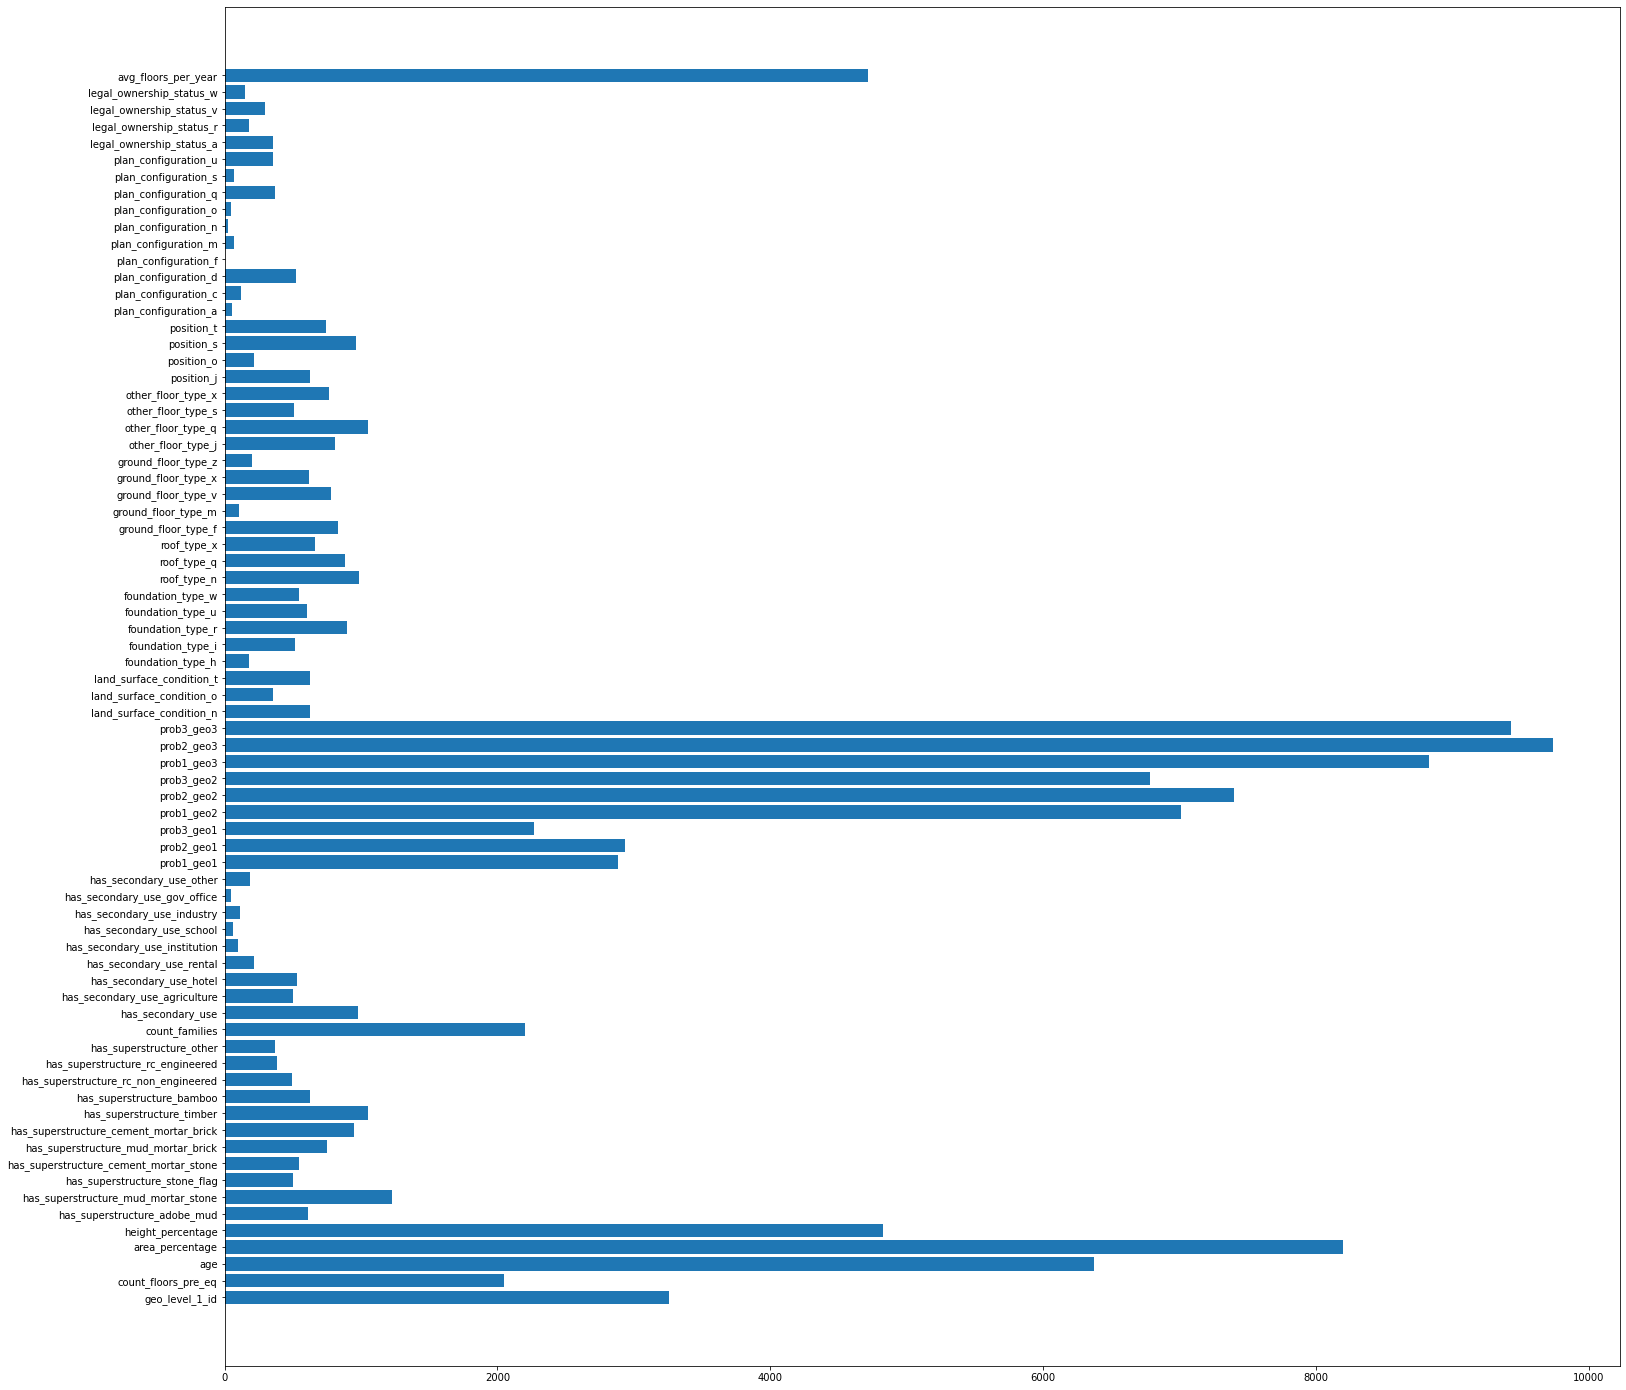

In [364]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, vcl.estimators_[1].feature_importances_)

<BarContainer object of 74 artists>

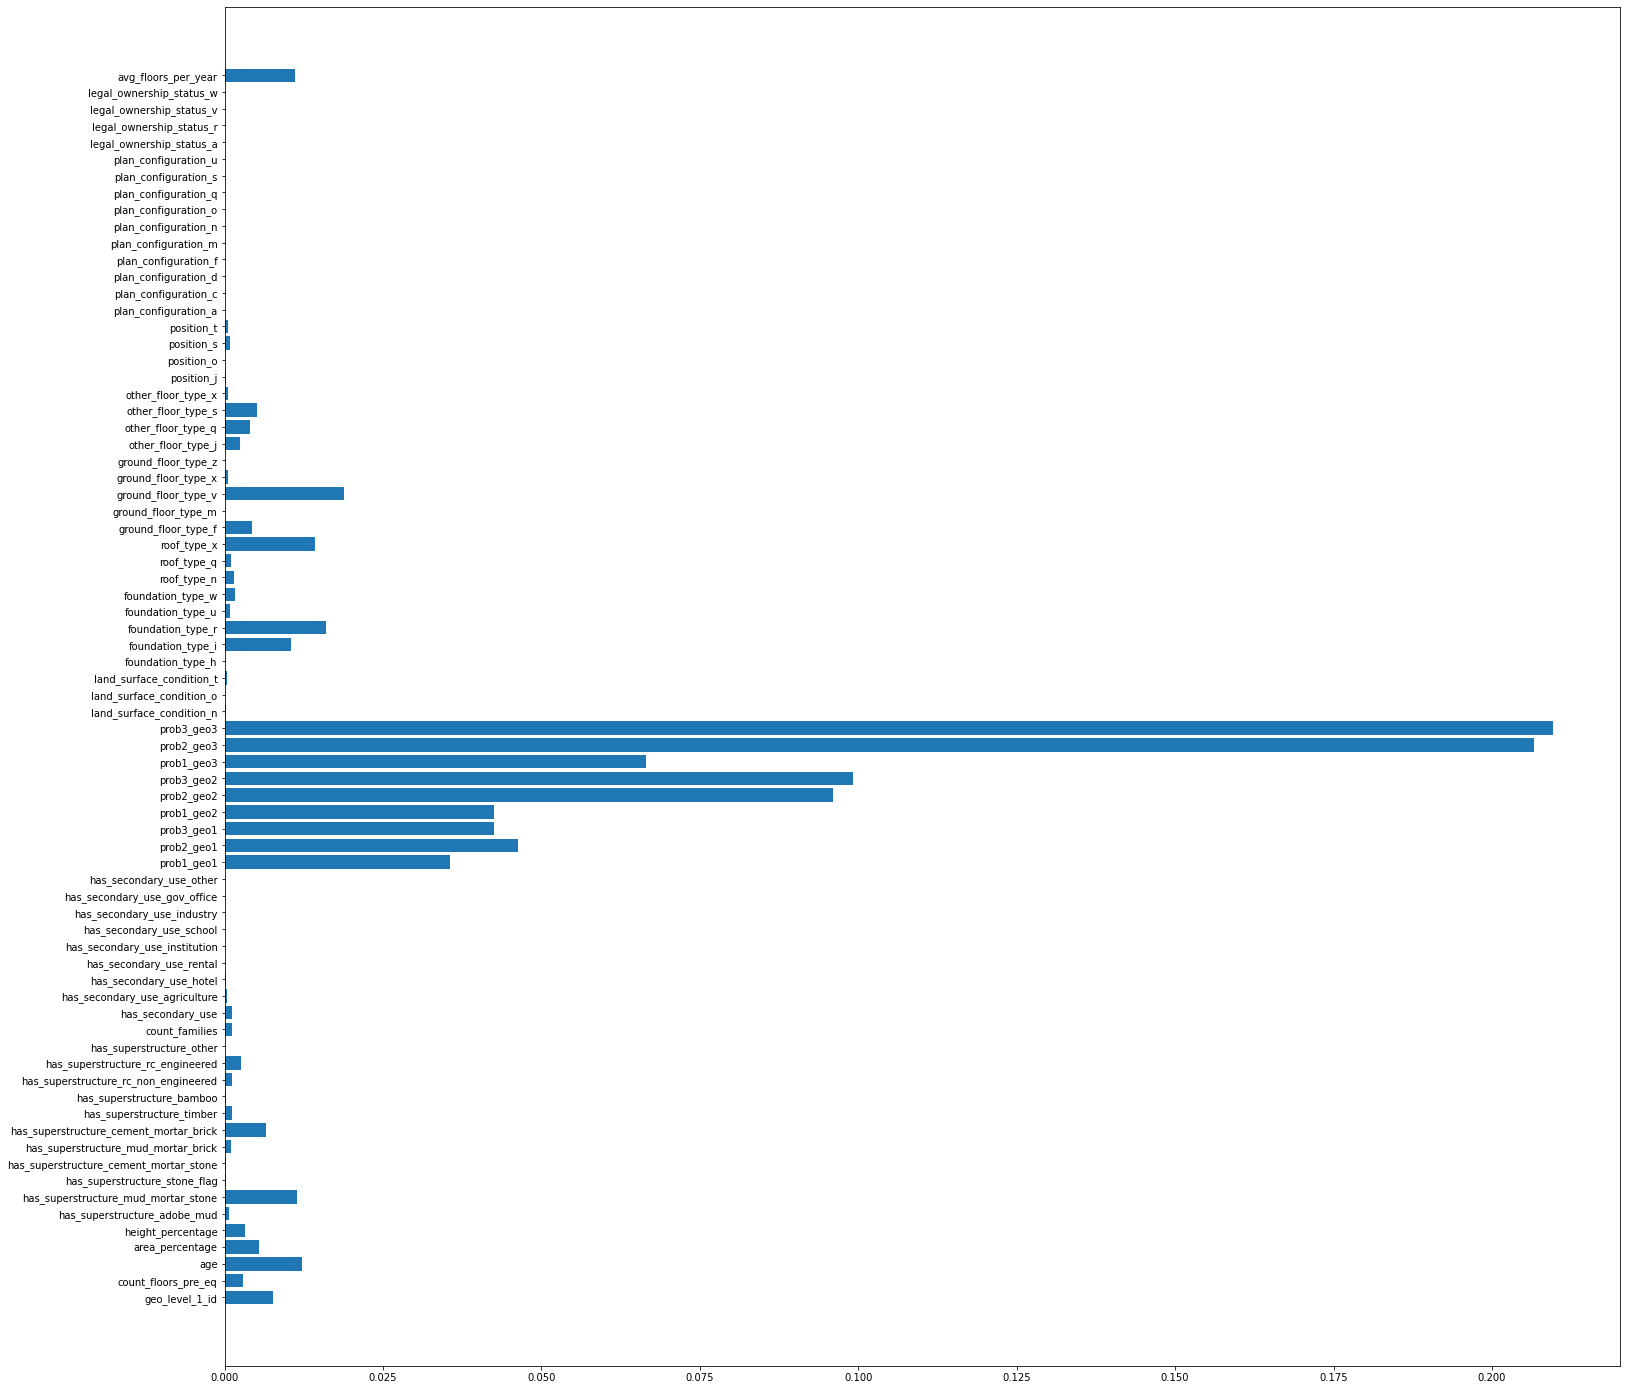

In [365]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, vcl.estimators_[2].feature_importances_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished


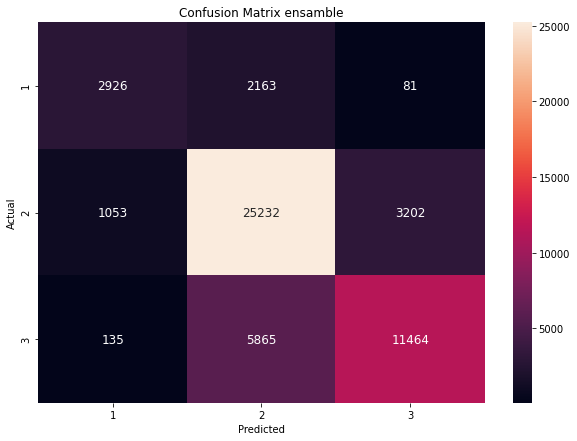

In [368]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in vcl.estimators_
], axis=0)

feature_importances


from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = vcl.predict(X_test)

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix ensamble")
plt.show()


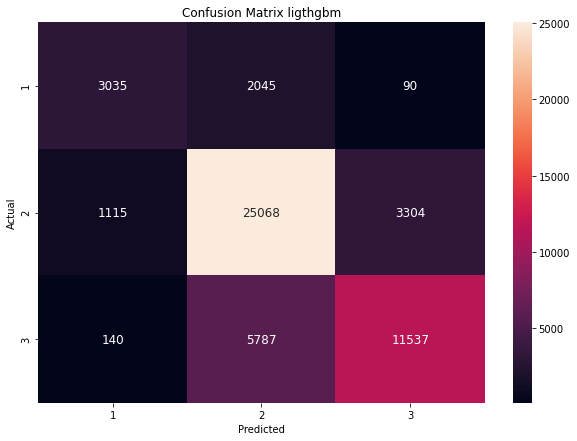

In [369]:
y_pred = vcl.estimators_[1].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix ligthgbm")
plt.show()


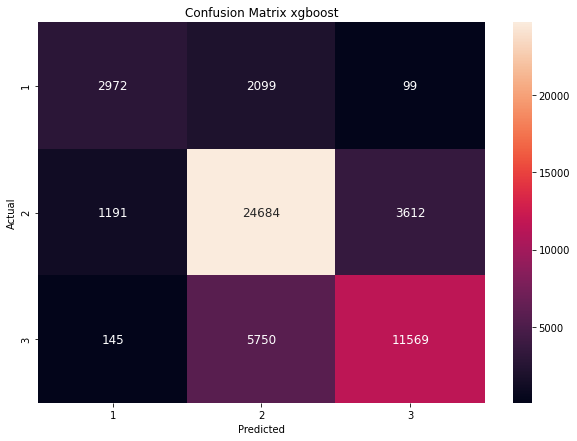

In [370]:
y_pred = vcl.estimators_[0].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix xgboost")
plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.7s finished


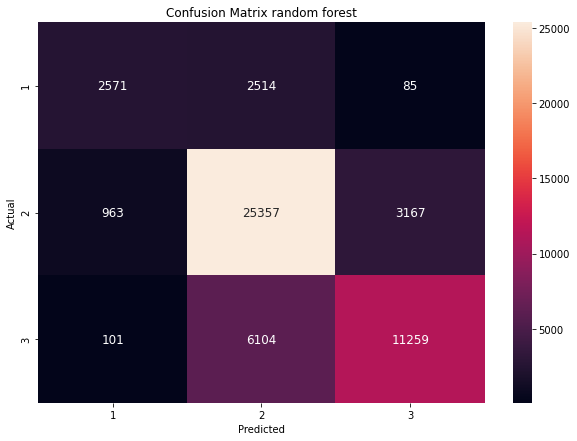

In [371]:
y_pred = vcl.estimators_[2].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix random forest")
plt.show()


hago el predict de los valores de test

In [352]:
pred_xgboost = vcl.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished


In [353]:
f1_score(y_test, pred_xgboost, average ='micro')

0.7601926286909307

predigo el df_test y creo el file contra el format csv

In [355]:
pred_xgboost_final = vcl.predict(df_test_encoding)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.0s finished


In [356]:
pred_xgboost_final

array([3, 2, 3, ..., 2, 2, 1])

In [357]:
df_final = pd.DataFrame()
df_final['building_id'] = building_id
df_final['damage_grade'] = pred_xgboost_final

In [358]:
df_final

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [359]:
df_final.to_csv('/content/drive/MyDrive/datasets_tp2/29072021_training-result.csv',index= False)

In [360]:
# submission_format = pd.read_csv('/content/drive/MyDrive/datasets_tp2/submission_format.csv', index_col='building_id')
# my_submission = pd.DataFrame(data=pred_xgboost_final,
#                              columns=submission_format.columns,
#                              index=submission_format.index)

In [361]:
# my_submission.head()

In [362]:
# fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
# my_submission.to_csv('/content/drive/MyDrive/datasets_tp2/training-result.csv',index= True)